# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Time-Analysis:-OSMI-Survey-2014---EDA" data-toc-modified-id="Time-Analysis:-OSMI-Survey-2014---EDA-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Analysis: OSMI Survey 2014 - EDA</a></div><div class="lev1 toc-item"><a href="#Summary-Statistics" data-toc-modified-id="Summary-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Summary Statistics</a></div><div class="lev2 toc-item"><a href="#Building-Diagnosis-Variable" data-toc-modified-id="Building-Diagnosis-Variable-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Building Diagnosis Variable</a></div><div class="lev2 toc-item"><a href="#Demographics" data-toc-modified-id="Demographics-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Demographics</a></div><div class="lev2 toc-item"><a href="#Employer-Variables" data-toc-modified-id="Employer-Variables-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Employer Variables</a></div>

# Time Analysis: OSMI Survey 2014 - EDA

_By [Michael Rosenberg](mailto:mmrosenb@andrew.cmu.edu)._

_**Description**: Contains my exploratory data analysis for the OSMI Survey performed in 2014._

_Last Updated: 4/27/2017 10:43 AM EST._

In [53]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

#constants
%matplotlib inline
sns.set_style("dark")
sigLev = 3
figWidth = figHeight = 5

In [7]:
#load in the dataset
surveyFrame = pd.read_csv("../../data/raw/osmi-survey-2014_data.csv")
laterFrame = pd.read_csv("../../data/raw/osmi-survey-2016_data.csv")

# Summary Statistics

In [8]:
print surveyFrame.shape
print laterFrame.shape

(1259, 27)
(1433, 63)


We see that we have only slightly fewer observations and way fewer features in the $2014$ data than in the $2016$ data. This in itself can have a major impact on our analysis, as it will limit what particular techniques we can use to incorporate time-varying effects for both datasets.

In [9]:
surveyFrame.columns

Index([u'Timestamp', u'Age', u'Gender', u'Country',
       u'If you live in the United States, which state or territory do you live in?',
       u'Are you self-employed?',
       u'Do you have a family history of mental illness?',
       u'Have you sought treatment for a mental health condition?',
       u'If you have a mental health condition, do you feel that it interferes with your work?',
       u'How many employees does your company or organization have?',
       u'Do you work remotely (outside of an office) at least 50% of the time?',
       u'Is your employer primarily a tech company/organization?',
       u'Does your employer provide mental health benefits?',
       u'Do you know the options for mental health care your employer provides?',
       u'Has your employer ever discussed mental health as part of an employee wellness program?',
       u'Does your employer provide resources to learn more about mental health issues and how to seek help?',
       u'Is your anonymity prote

_Table 1: List of variables available in the $2014$ data._

Thankfully, age, gender, country, and company size look to be intact for our analysis. Unfortunately, it seems as though worker type seems to be left out of the analysis. This is slightly concerning, although it is not entirely worrisome given the limited need for that vaariable in our previous analyses. We can also try to incorporate aspects of the company type (i.e. if it's primarily tech or not) given the relevance of said variable in our previous analysis.

Let's try to measure mental health condition using "If you have a mental health condition, do you feel that it interferes with your work?". We can see if the distribution looks similar to that of our previous analysis.

## Building Diagnosis Variable

In [12]:
surveyFrame["diagnosedWithMHD"] = 1
surveyFrame.loc[surveyFrame["If you have a mental health condition, do you feel that it interferes with your work?"].isnull(),
                "diagnosedWithMHD"] = 0

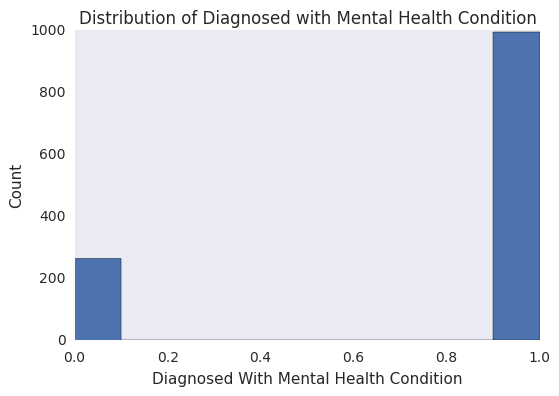

In [14]:
plt.hist(surveyFrame["diagnosedWithMHD"])
plt.ylabel("Count")
plt.xlabel("Diagnosed With Mental Health Condition")
plt.title("Distribution of Diagnosed with Mental Health Condition")

_Figure 1: Distribution of Diagnosed with mental health condition._

This is not the 50-50 distribution that we had hoped for in our prior analysis. Thus, we will need to consider some other variables to get a more preferred distribution to what we had previously.

Let's try to say that one has a mental health condition if they have been treated for it. It's a flawed method to go about our analysis, but it may be our only chance at this point.

In [16]:
surveyFrame["diagnosedWithMHD"] = 0
surveyFrame.loc[surveyFrame['Have you sought treatment for a mental health condition?'] == "Yes",
                "diagnosedWithMHD"] = 1

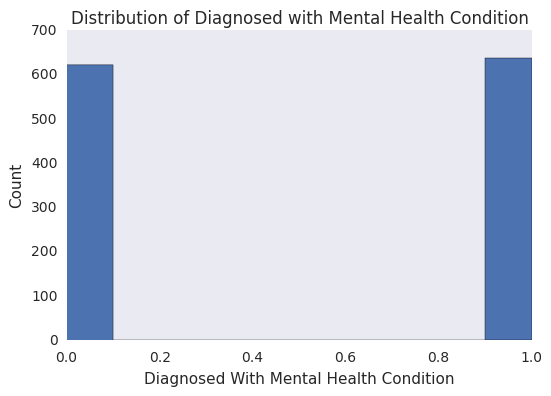

In [33]:
plt.hist(surveyFrame["diagnosedWithMHD"])
plt.ylabel("Count")
plt.xlabel("Diagnosed With Mental Health Condition")
plt.title("Distribution of Diagnosed with Mental Health Condition")

_Figure 2: Distribution of our current measure of diagnosis with a mental health condition._

This is the closest we will get to the desired $50$-$50$ distribution we see in our previous analysis. Thus, this may be our current metric for considering those who are diagnosed in our dataset.

## Demographics

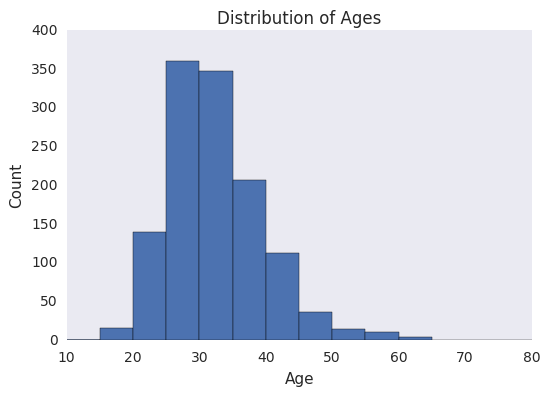

In [38]:
binRange = range(10,200,5)
plt.hist(surveyFrame["Age"],bins = binRange)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Ages")

_Figure 3: Distribution of Ages of Respondents to the Survey in 2014._

We see no obvious outliers, although the distribution generally favors younger individuals over older ones. This is expected for the tech industry, which is known for having strong issues with ageism.

In [42]:
for gender in surveyFrame["Gender"].unique():
    print gender

Female
M
Male
male
female
m
Male-ish
maile
Trans-female
Cis Female
F
something kinda male?
Cis Male
Woman
f
Mal
Male (CIS)
queer/she/they
non-binary
Femake
woman
Make
Nah
All
Enby
fluid
Genderqueer
Female 
Androgyne
Agender
cis-female/femme
Guy (-ish) ^_^
male leaning androgynous
Male 
Man
Trans woman
msle
Neuter
Female (trans)
queer
Female (cis)
Mail
cis male
A little about you
Malr
p
femail
Cis Man
ostensibly male, unsure what that really means


We see that there are about {{len(surveyFrame["Gender"].unique())}} levels of gender expressed in this survey. We will assign these to the three groups discussed before, although we may try some other encodings for more granularity for non-binary individuals in the survey.

In [46]:
#get distribution of countries
countryCountFrame = surveyFrame.groupby("Country",as_index = False)[
                                                        "Gender"].count()
countryCountFrame = countryCountFrame.rename(columns = {"Gender":"Count"})

We see that we have {{countryCountFrame.shape[0]}} represented in this dataset. Let's see how sparse this distribution is.

In [48]:
countryCountFrame = countryCountFrame.sort_values("Count",ascending = False)
countryCountFrame["density"] = (countryCountFrame["Count"] 
                                / np.sum(countryCountFrame["Count"]))
countryCountFrame["rank"] = range(countryCountFrame.shape[0])

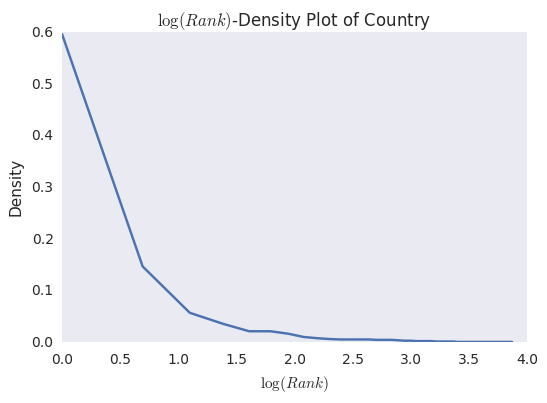

In [50]:
plt.plot(np.log(countryCountFrame["rank"] + 1),countryCountFrame["density"])
plt.xlabel("$\log(Rank)$")
plt.ylabel("Density")
plt.title("$\log(Rank)$-Density Plot of Country")

_Figure 4: $\log(Rank)$-Density Plot of Country in the 2014 survey._

We see that the top $e^2 \approx 7$ countries account for most of the country distribution, which is relatively sparse. This again suggests that an "isUSA" encoding should be considered, although it might be useful to also consider some of the locational effects of some of the other large donors to this distribution.

In [54]:
topLev = 7
topCountryCountFrame = countryCountFrame.iloc[0:topLev,:]
display(topCountryCountFrame)

,Country,Count,density,rank
45,United States,751,0.596505,0
44,United Kingdom,185,0.146942,1
7,Canada,72,0.057188,2
17,Germany,45,0.035743,3
28,Netherlands,27,0.021446,4
21,Ireland,27,0.021446,5
0,Australia,21,0.016680,6


_Table 2: The top $7$ most frequent countries in our dataset._

We see that like our previous example, the United States takes up a large portion of the distribution. That being said, the United Kingdom does as well, which may suggest that we should consider that locational effect as well in our interpretations.

As expected the top $7$ countries look to be primarily based in Europe and North America, which suggests that this survey is biased towards those tech industries. This was similar to the $2016$ survey, so we are not entirely concerned there.

## Employer Variables

In [58]:
nullSections = surveyFrame[
    surveyFrame["How many employees does your company or organization have?"].isnull()]
print nullSections.shape

(0, 28)


Thankfully, it looks as though there are no null sections for this component of the survey. This means that we will not need to re-encode it in this context.

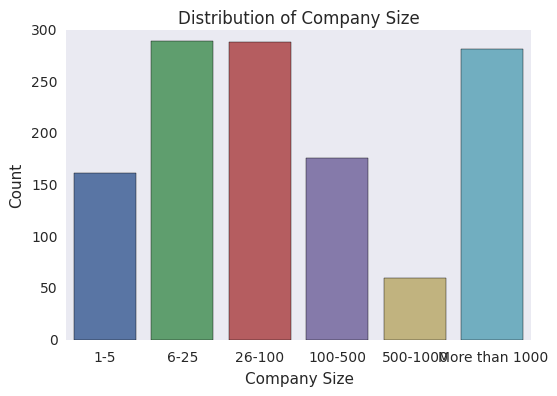

In [63]:
companySizeCountFrame = surveyFrame.groupby(
    "How many employees does your company or organization have?",
    as_index = False)["Gender"].count()
#reorder and rename
companySizeCountFrame = companySizeCountFrame.rename(
                                                columns = {"Gender":"count"})
companySizeCountFrame = companySizeCountFrame.loc[[0,4,2,1,3,5],:]
#then plot
sns.barplot(x = "How many employees does your company or organization have?",
            y = "count",data = companySizeCountFrame)
plt.xlabel("Company Size")
plt.ylabel("Count")
plt.title("Distribution of Company Size")

_Figure 5: Distribution of Company Size._

We see that most companies tend to either be around the small-to-mid sized range ($6-100$) and also around the rather large range ($>1000$). This may represent the divide between startups and established companies within the tech industry.

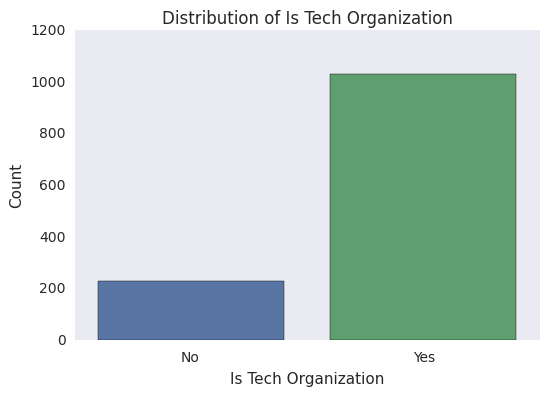

In [68]:
techOrgCountFrame = surveyFrame.groupby(
    'Is your employer primarily a tech company/organization?',as_index = False)[
    "Gender"].count()
techOrgCountFrame = techOrgCountFrame.rename(columns = {"Gender":"count"})
sns.barplot(x = 'Is your employer primarily a tech company/organization?',
            y = "count",data = techOrgCountFrame)
plt.xlabel("Is Tech Organization")
plt.ylabel("Count")
plt.title("Distribution of Is Tech Organization")

_Figure 6: Distribution of "Is Tech Organization" for the employers of our respondents._

We see that most individuals work at primarily tech companies, as is the nature of this survey. It would be useful to have in later surveys more granularity about the particular industries certain individuals work in.